In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
!wget https://transfer.sh/WDixNVtbbX/t.ext
!wget https://transfer.sh/OaS5vr9qpk/x.ext

t_filename = '/content/t.ext'  ## change this to your path
x_filename = '/content/x.ext'  ## change this to your path

# Use read_csv with custom delimiter (assuming it's a space-separated file)
t_data = pd.read_csv(t_filename, header=None, comment='%', delim_whitespace=True)
x_data = pd.read_csv(x_filename, header=None, comment='%', delim_whitespace=True)

X = x_data.to_numpy()
t = t_data.to_numpy().flatten()

--2023-12-07 14:48:51--  https://transfer.sh/WDixNVtbbX/t.ext
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24 [application/vnd.novadigm.ext]
Saving to: ‘t.ext.1’

t.ext.1             100%[===================>]      24  --.-KB/s    in 0s      

2023-12-07 14:48:52 (13.0 MB/s) - ‘t.ext.1’ saved [24/24]

--2023-12-07 14:48:52--  https://transfer.sh/OaS5vr9qpk/x.ext
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73 [application/vnd.novadigm.ext]
Saving to: ‘x.ext.1’

x.ext.1             100%[===================>]      73  --.-KB/s    in 0s      

2023-12-07 14:48:52 (59.8 MB/s) - ‘x.ext.1’ saved [73/73]



In [ ]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the likelihood function
def likelihood(w, X, t):
    y = sigmoid(X @ w)
    G = -np.sum(t * np.log(y) + (1 - t) * np.log(1 - y))
    return np.exp(-G)

# Define the prior function
def prior(w, alpha):
    EW = 0.5 * np.dot(w, w)  # Assuming a zero-mean Gaussian prior
    ZW = (2 * np.pi / alpha) ** (len(w) / 2)  # Normalization constant
    return np.exp(-alpha * EW) / ZW

# Define the posterior function (negative log posterior here for minimization)
def neg_log_posterior(w, X, t, alpha):
    return -np.log(likelihood(w, X, t) * prior(w, alpha))

# Hessian as in the slides
def hessian(w_star, X, alpha):
    # Calculate h for each data point
    h = X @ w_star
    # Precompute sigma(h) and sigma(-h) for efficiency
    sigma_h = sigmoid(h)
    sigma_neg_h = sigmoid(-h)

    # Initialize the Hessian matrix
    H = np.zeros((X.shape[1], X.shape[1]))

    # Compute the Hessian matrix
    for mu in range(X.shape[0]):
        for i in range(X.shape[1]):
            for j in range(X.shape[1]):
                H[i, j] += sigma_h[mu] * sigma_neg_h[mu] * X[mu, i] * X[mu, j]

    # add the alpha times the identity matrix (regularization term)
    H += alpha * np.eye(X.shape[1])

    return H

# calculate posterior using Laplace approximation as in slides
def posterior(w_star, H_inv, X):
    a = np.dot(X, w_star)
    s = np.sum((X @ H_inv) * X, axis=1)
    return sigmoid(a / np.sqrt((1 + np.pi * s) / 8))

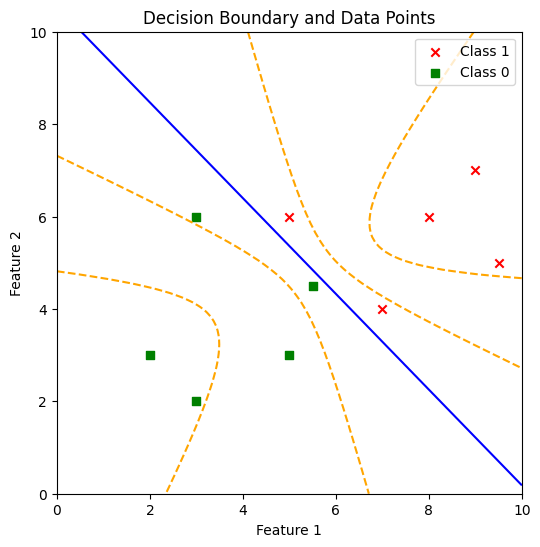

In [ ]:
# Initial guess for w
w_init = np.random.randn(X.shape[1])

# Minimize the negative log posterior to find find w* (MAP estimate)
alpha = .001  # Assuming some alpha
res = minimize(neg_log_posterior, w_init, args=(X, t, alpha), method='BFGS')

w_star = res.x  # MAP estimate of w

# Now calculate the Hessian at w*
H = hessian(w_star, X, alpha)
H_inv = np.linalg.inv(H)  # Inverse Hessian

# Define the grid for visualization
grid_x = np.linspace(0, 10, 100)
grid_y = np.linspace(0, 10, 100)
grid_X, grid_Y = np.meshgrid(grid_x, grid_y)
grid = np.c_[grid_X.ravel(), grid_Y.ravel()]

# Add a column of ones for the bias term
grid = np.c_[np.ones(grid.shape[0]), grid]

# compute
grid_prob = posterior(w_star, H_inv, grid).reshape(grid_X.shape)

# Correct the marker style and plot again
plt.figure(figsize=(6,6))
plt.contour(grid_X, grid_Y, grid_prob, levels=[0.0995], colors='orange', linestyles = 'dashed')
plt.contour(grid_X, grid_Y, grid_prob, levels=[0.17], colors='orange', linestyles = 'dashed')
plt.contour(grid_X, grid_Y, grid_prob, levels=[0.5], colors='blue')
plt.contour(grid_X, grid_Y, grid_prob, levels=[0.83], colors='orange', linestyles = 'dashed')
plt.contour(grid_X, grid_Y, grid_prob, levels=[0.905], colors='orange', linestyles = 'dashed')
plt.scatter(X[t == 1, 1], X[t == 1, 2], c='red', marker='x', label='Class 1')
plt.scatter(X[t == 0, 1], X[t == 0, 2], c='green', marker='s', label='Class 0')  # Corrected marker
plt.title('Decision Boundary and Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()